In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device.')

Using cuda device.


Attribute of ImageFolder class to retrieve filename of images and set them to classes:
* img_data.imgs

Attribute of ImageFolder class to retrieve labels (0, 1) of images based on folder:
* img_data.targets

In [3]:
seed_value = 42

def set_random_seeds(seed_value):
    # Set the seed for the random number generators in various libraries
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)

# Set the random seeds
set_random_seeds(seed_value)

In [4]:
# Loading the images from training folder
img_data = datasets.ImageFolder('../input/cat-and-dog/training_set/training_set')
        
# Split data
train_X, val_X, train_y, val_y = train_test_split(img_data.imgs, img_data.targets, test_size=0.2, random_state=42)

# Load and preprocess images data
class ImageDataset(Dataset):
    def __init__(self, img_data, transform=None):
        # Select only RGB images
        self.img_data = [img for img in img_data if Image.open(img[0]).mode == 'RGB']
        self.transform = transform
    
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, idx):
        image_path, label = self.img_data[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

    
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Desired Resnet image size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Desired Resnet normalization values
])

# Create dataset
train_data = ImageDataset(train_X, transform)
val_data = ImageDataset(val_X, transform)

# Prepare training and validation data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Number of training & validation images
print(f'Training images: {len(train_data)}\nValidation images: {len(val_data)}')

Training images: 6404
Validation images: 1601


In [5]:
def visualize_data():
    # Visualize random images sample before transformation
    labels_map = {
        0: "Cat",
        1: "Dog",
    }
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_X[sample_idx]
        img = Image.open(img)
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.resize((224, 224)))
    plt.show()

In [6]:
# Set model
model = models.resnet18(weights='DEFAULT')

# Update autograd parameters status to prevent SGD 
for param in model.parameters():
    param.required_grad = False

# Change the fully connected last layer parameters input & output 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler (weight decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
# Restart the model parameters
# import os
# os.remove('/kaggle/working/best_model_params.pt')

In [9]:
def train_model(model, criterion, optimizer, num_epochs):  
    # Set path to best model performance
    best_model_params_path = "/kaggle/working/best_model_params.pt"
    torch.save(model.state_dict(), best_model_params_path)
    
    best_acc = 0.0
    
    # Store loss and acc of each epoch
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set train mode
        model.train()
        
        # Set up a progress bar for epochs
        epoch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')
        
        running_train_loss = 0.0
        running_train_acc = 0
        
        # Iterate over data.
        for batch_idx, (inputs, targets) in epoch_progress:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)            

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            # Backward, parameters optimization
            loss.backward()
            optimizer.step()
            
            # Gather losses for statistics purposes
            running_train_loss += loss.item() * inputs.size(0)
            running_train_acc += torch.sum(preds == targets.data)
            
        scheduler.step()

        # Calculate training loss and accuracy
        t_loss = running_train_loss / len(train_loader.dataset)
        t_acc = running_train_acc.double() / len(train_loader.dataset)
        
        train_losses.append(t_loss)
        train_acc.append(t_acc)
                                
        # Evaluation mode
        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_loss = criterion(outputs, targets)
                
                running_val_acc += torch.sum(preds == targets.data)
                running_val_loss += val_loss.item() * inputs.size(0)
            
            v_loss = running_val_loss / len(val_loader.dataset)
            v_acc = running_val_acc.double() / len(val_loader.dataset)
            
            val_losses.append(v_loss)
            val_acc.append(v_acc)
            
            if v_acc > best_acc:
                best_acc = v_acc
                torch.save(model.state_dict(), best_model_params_path)
                
        tqdm.write(f'Epoch {epoch+1}/{num_epochs} - '
                   f'Train Loss: {t_loss:.4f} - '
                   f'Train Accuracy: {t_acc:.2%} - '
                   f'Validation Loss: {v_loss:.4f} - '
                   f'Validation Accuracy: {v_acc:.2%}')
        
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, val_losses, train_acc, val_acc

In [10]:
best_model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, 20)

Epoch 1/20: 100%|██████████| 101/101 [00:50<00:00,  2.00it/s]


Epoch 1/20 - Train Loss: 0.1782 - Train Accuracy: 92.41% - Validation Loss: 0.1741 - Validation Accuracy: 93.13%


Epoch 2/20: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]


Epoch 2/20 - Train Loss: 0.1270 - Train Accuracy: 95.05% - Validation Loss: 0.1442 - Validation Accuracy: 94.19%


Epoch 3/20: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


Epoch 3/20 - Train Loss: 0.1862 - Train Accuracy: 92.36% - Validation Loss: 0.2159 - Validation Accuracy: 92.25%


Epoch 4/20: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]


Epoch 4/20 - Train Loss: 0.1532 - Train Accuracy: 94.00% - Validation Loss: 0.1203 - Validation Accuracy: 95.13%


Epoch 5/20: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]


Epoch 5/20 - Train Loss: 0.0684 - Train Accuracy: 97.22% - Validation Loss: 0.2606 - Validation Accuracy: 91.88%


Epoch 6/20: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]


Epoch 6/20 - Train Loss: 0.0661 - Train Accuracy: 97.44% - Validation Loss: 0.1126 - Validation Accuracy: 95.32%


Epoch 7/20: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


Epoch 7/20 - Train Loss: 0.0607 - Train Accuracy: 97.85% - Validation Loss: 0.1427 - Validation Accuracy: 94.69%


Epoch 8/20: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


Epoch 8/20 - Train Loss: 0.0588 - Train Accuracy: 97.72% - Validation Loss: 0.1774 - Validation Accuracy: 94.25%


Epoch 9/20: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]


Epoch 9/20 - Train Loss: 0.0376 - Train Accuracy: 98.64% - Validation Loss: 0.2057 - Validation Accuracy: 93.13%


Epoch 10/20: 100%|██████████| 101/101 [00:44<00:00,  2.27it/s]


Epoch 10/20 - Train Loss: 0.0331 - Train Accuracy: 98.61% - Validation Loss: 0.1565 - Validation Accuracy: 93.50%


Epoch 11/20: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]


Epoch 11/20 - Train Loss: 0.0275 - Train Accuracy: 99.08% - Validation Loss: 0.1200 - Validation Accuracy: 95.69%


Epoch 12/20: 100%|██████████| 101/101 [00:43<00:00,  2.33it/s]


Epoch 12/20 - Train Loss: 0.0123 - Train Accuracy: 99.56% - Validation Loss: 0.1391 - Validation Accuracy: 95.07%


Epoch 13/20: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


Epoch 13/20 - Train Loss: 0.0067 - Train Accuracy: 99.83% - Validation Loss: 0.1251 - Validation Accuracy: 95.69%


Epoch 14/20: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]


Epoch 14/20 - Train Loss: 0.0066 - Train Accuracy: 99.77% - Validation Loss: 0.1374 - Validation Accuracy: 95.94%


Epoch 15/20: 100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


Epoch 15/20 - Train Loss: 0.0036 - Train Accuracy: 99.95% - Validation Loss: 0.1330 - Validation Accuracy: 96.00%


Epoch 16/20: 100%|██████████| 101/101 [00:43<00:00,  2.30it/s]


Epoch 16/20 - Train Loss: 0.0043 - Train Accuracy: 99.94% - Validation Loss: 0.1274 - Validation Accuracy: 96.50%


Epoch 17/20: 100%|██████████| 101/101 [00:44<00:00,  2.28it/s]


Epoch 17/20 - Train Loss: 0.0179 - Train Accuracy: 99.48% - Validation Loss: 0.1463 - Validation Accuracy: 95.82%


Epoch 18/20: 100%|██████████| 101/101 [00:44<00:00,  2.28it/s]


Epoch 18/20 - Train Loss: 0.0281 - Train Accuracy: 99.17% - Validation Loss: 0.1345 - Validation Accuracy: 95.82%


Epoch 19/20: 100%|██████████| 101/101 [00:45<00:00,  2.23it/s]


Epoch 19/20 - Train Loss: 0.0094 - Train Accuracy: 99.73% - Validation Loss: 0.1386 - Validation Accuracy: 96.19%


Epoch 20/20: 100%|██████████| 101/101 [00:45<00:00,  2.24it/s]


Epoch 20/20 - Train Loss: 0.0057 - Train Accuracy: 99.86% - Validation Loss: 0.1261 - Validation Accuracy: 96.19%


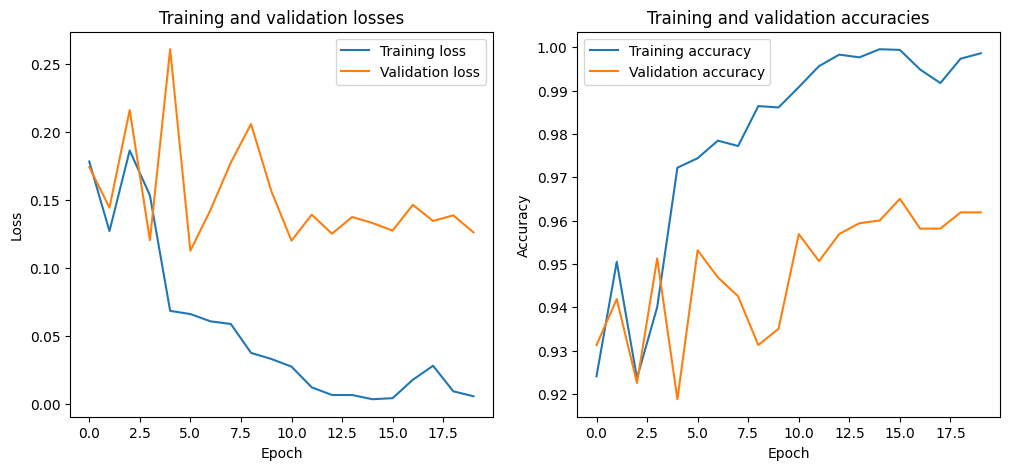

In [11]:
def visualize_loss_acc():
    # Move accuracies from CUDA tensor to CPU before plotting
    train_acc_cpu = [tensor.to('cpu') for tensor in train_acc]
    val_acc_cpu = [tensor.to('cpu') for tensor in val_acc]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    ax1.plot(train_loss, label='Training loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and validation losses')
    
    ax2.plot(train_acc_cpu, label='Training accuracy')
    ax2.plot(val_acc_cpu, label='Validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training and validation accuracies')
    
    plt.show()

visualize_loss_acc()

In [12]:
# Prepare the test set for prediction
test_dataset = datasets.ImageFolder("../input/cat-and-dog/test_set/test_set/", transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
def inverse_transform(img_tensor):
    invTrans = transforms.Compose(
        [transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0])]
    )
    
    inversed_img = invTrans(img_tensor)
    return inversed_img


def visualize_data(model, num_images=6):
    class_labels = {
       0: "Cat",
       1: "Dog",
   }   

    figure = plt.figure(figsize=(12, 12))
    cols, rows = 3, 3
    images_so_far = 0
    
    model.eval() # Set the model to evaluation mode
   
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            if images_so_far == num_images:
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)
            _, predicted_class = torch.max(output, 1)

            # Inverse transformation image
            inputs = inverse_transform(inputs)
            
            # Convert the input image to a NumPy array for visualization
            input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().numpy()

            figure.add_subplot(rows, cols, images_so_far + 1)
            plt.title(f"Actual: {class_labels[targets.item()]}, Predicted: {class_labels[predicted_class.item()]}")
            plt.axis("off")
            plt.imshow(input_image)

            images_so_far += 1

    plt.show()

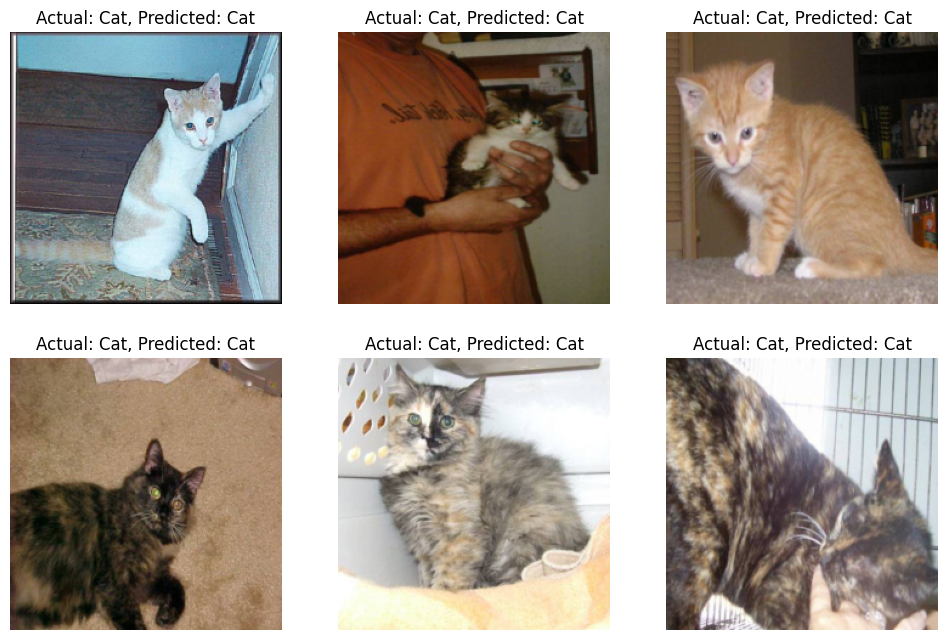

In [14]:
visualize_data(best_model)